## Examine the effect of going to Catholic school vs Public school.
#### Data from 'Early Childhood Longitudinal Study' is downloaded from https://www.researchconnections.org/childcare/studies/4075?q=c5r2mtsc&type=Data+Sets
Data preprocessing work is based on the work of sejdemyr 'https://github.com/sejdemyr/ecls'.

In [1]:
import sys
sys.path.append('/analytics/shared/packages/')

In [2]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm
from statsmodels.formula import api
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
import numpy as np

In [3]:
df = pd.read_csv('data/ecls.csv', encoding='UTF-8')
df.sample(5)

,childid,catholic,race,race_white,race_black,race_hispanic,race_asian,p5numpla,p5hmage,p5hdage,...,w3daded_hsb,w3momed_hsb,w3momscr,w3dadscr,w3inccat,w3income,w3povrty,p5fstamp,c5r2mtsc,c5r2mtsc_std
6183,0785008C,0,"WHITE, NON-HISPANIC",1,0,0,0,1.0,42.0,45.0,...,0.0,1.0,38.18,33.42,"$40,001 TO $50,000",45000.5,0.0,0.0,48.455,-0.211154
3164,0404011C,1,"WHITE, NON-HISPANIC",1,0,0,0,1.0,36.0,38.0,...,0.0,0.0,77.50,53.50,"$50,001 TO $75,000",62500.5,0.0,0.0,61.439,1.125462
9681,1253025C,1,"HISPANIC, RACE NOT SPECIFIED",0,0,1,0,1.0,31.0,37.0,...,0.0,0.0,34.95,NaN,"$5,000 TO $5,000",5000.0,1.0,0.0,58.775,0.851221
10509,3030003C,0,"WHITE, NON-HISPANIC",1,0,0,0,1.0,41.0,38.0,...,0.0,0.0,48.69,35.92,"$50,001 TO $75,000",62500.5,0.0,0.0,60.365,1.014901
2521,0330004C,0,"WHITE, NON-HISPANIC",1,0,0,0,2.0,38.0,44.0,...,1.0,0.0,35.92,39.18,"$50,001 TO $75,000",62500.5,0.0,0.0,57.548,0.724910


## 1.Pre-Analysis using non-matched data
### 1.1 Difference in means: outcome variables

Looking at students standaridized match score (c5r2mtsc_std) of students from catholic ( catholic = 1) and public (catholic = 0) schools.

In [4]:
df[['childid', 'catholic', 'c5r2mtsc_std']].groupby(['catholic']).agg(['count','mean',stats.sem])

c5r2mtsc_std                    
                count      mean       sem
catholic                                 
0                9568 -0.030596  0.010385
1                1510  0.193868  0.022353

Since math score is standarized, we can conclude that the catholic students average math score is more than 20% of a standard deviation higher than that of public students.

In [5]:
stats.ttest_ind(df[df.catholic == 1]['c5r2mtsc_std'],df[df.catholic == 0]['c5r2mtsc_std'] )

Ttest_indResult(statistic=8.129941988954517, pvalue=4.752225684279406e-16)

Also from the ttest, we can see that the difference in average math score is statistiaclly significant. 

### 1.2 Difference in means: pre-treatment covariates

Covariates: <br>
    race_white: 1=yes, 0=No <br>
    p5hmage: mothers age <br>
    w3income: family income <br>
    p5numpla: number of places student has lived for at least 4 months <br>
    w3momed_hsb: is mothers education highschool or below(1), or college degree/more (0)

### Mean for each covariates

In [6]:
(df[['catholic', 'race_white', 'p5hmage','w3income','p5numpla','w3momed_hsb']]
 .groupby(['catholic']).agg(['mean']))

,race_white,p5hmage,w3income,p5numpla,w3momed_hsb
,mean,mean,mean,mean,mean
catholic,,,,,
0,0.556125,37.560970,54889.159064,1.132669,0.464092
1,0.725166,39.575163,82074.300501,1.092701,0.227207


In [7]:
for x in ['race_white', 'p5hmage','w3income','p5numpla','w3momed_hsb']:
    print("Variable: " + x)
    print(stats.ttest_ind(df[df.catholic == 1][x].dropna(),df[df.catholic == 0][x].dropna()))


Variable: race_white
Ttest_indResult(statistic=12.450367999574826, pvalue=2.398953024611241e-35)
Variable: p5hmage
Ttest_indResult(statistic=10.793536203115156, pvalue=5.302915317001201e-27)
Variable: w3income
Ttest_indResult(statistic=21.29597069456485, pvalue=2.161494782851299e-98)
Variable: p5numpla
Ttest_indResult(statistic=-3.5239085421140763, pvalue=0.0004272306475610962)
Variable: w3momed_hsb
Ttest_indResult(statistic=-16.68066304714088, pvalue=1.3607115748238347e-61)


From the p-value, we can see that all mean differences are statistically significant.

## 2 Propensity Score Matching

In [78]:
students = df[['catholic','race_white','w3income','p5hmage', 'p5numpla','w3momed_hsb']].dropna().copy()
students['w3income_1k'] = students['w3income'].apply(lambda x: x/1000)
students = students.drop('w3income', axis=1)
students = students.reset_index().drop('index', axis=1)
students.sample(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,w3income_1k
1786,0,1,36.0,1.0,0.0,87.5005
8943,0,1,34.0,1.0,0.0,87.5005
7598,0,0,37.0,1.0,0.0,62.5005
7381,0,0,29.0,1.0,1.0,45.0005
3273,0,1,32.0,1.0,0.0,27.5005


In [79]:
students.dtypes

catholic         int64
race_white       int64
p5hmage        float64
p5numpla       float64
w3momed_hsb    float64
w3income_1k    float64
dtype: object

In [80]:
lor = LogisticRegression()
propensity = lor.fit(students.loc[:, students.columns != 'catholic'], students.catholic)
pscore = propensity.predict_proba(students.loc[:, students.columns != 'catholic'])[:,1]
# probability is ordered on class lebel

# score from Logistic Regression
students['prop_score'] = pscore

In [81]:
lor.intercept_

array([-3.04773578])

In [82]:
lor.coef_

array([[ 0.3043212 ,  0.02616123, -0.17243479, -0.70163013,  0.00728416]])

In [83]:
y, X = dmatrices('catholic ~ C(race_white) + p5hmage + p5numpla + w3momed_hsb + w3income_1k', 
                 students, return_type = 'dataframe')

In [84]:
logit = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.386794
         Iterations 7


In [85]:
logit.params

Intercept            -3.212552
C(race_white)[T.1]    0.314501
p5hmage               0.029217
p5numpla             -0.143939
w3momed_hsb          -0.693587
w3income_1k           0.007304
dtype: float64

In [86]:
# Adding score from logit model as well
# Logistic regression has L2 regularization by default. So the ps score from LR and Logit might not match
students['logit_score'] = logit.predict(X)

In [87]:
students.sample(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,w3income_1k,prop_score,logit_score
8953,0,0,34.0,1.0,0.0,200.0010,0.294454,0.288568
2256,1,1,43.0,1.0,0.0,150.0005,0.332192,0.334013
3277,1,1,35.0,1.0,1.0,62.5005,0.095646,0.094791
5302,0,1,42.0,1.0,0.0,27.5005,0.165652,0.166030
5446,0,0,30.0,1.0,0.0,27.5005,0.096650,0.092866


Notice the prop_score from Logistic Regression and logit_score from Logit function. They do not match exactly and are pretty close.

Text(0.5,0.98,'Probability of going to Catholic School')

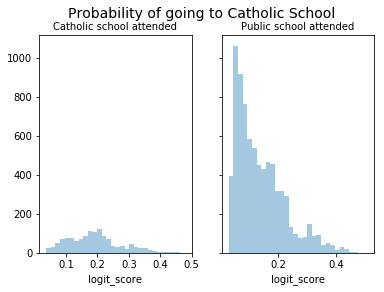

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.distplot(students[students.catholic == 1]['logit_score'], bins= 30, kde=False, hist=True, ax= ax1)
sns.distplot(students[students.catholic == 0]['logit_score'], bins= 30, kde=False, hist=True, ax= ax2)
ax1.set_title("Catholic school attended", fontsize=10)
ax2.set_title("Public school attended", fontsize=10)
fig.suptitle("Probability of going to Catholic School", fontsize=14)

## 3 Matching Algorithm

In [166]:
np.random.seed(10)

def Match(groups, pscore, caliper=0.05):
    '''
    Inputs: 
    groups = indicator to identify control and study group. Must be two groups. Number of treated (study) records should be
            smaller than untreated (control) records.
    pscore = propensity scores for each observation. Groups and pscore must be in the same order ( same indices).
    caliper = maximum difference in matched propensity scores.
    
    Outputs:
    returns a dataframe with four columns
    std_indx: index of the study record
    std_pscore: propensity score of the study record used for matching
    ctl_indx: index of control record that matches with the study record
    ctl_pscore: propensity score of the control record used for matching
    
    '''
    if any(pscore <= 0) or any(pscore >= 1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups) != len(pscore):
        raise ValueError('groups and pscore must have same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
     
    
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); 
    N2 = N - N1;
    g1, g2 = (pscore[groups == 1]),(pscore[groups == 0])
    # N1 is study, N2 is control
    # assuming number of study groups is less than control groups
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1

    if (N1 != len(g1)) or (N2 != len(g2)):
        raise ValueError('Number of study records must be less than control records')

    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN

    for m in morder:
        dist = abs(g1.iloc[m] - g2)
        if dist.min() <= caliper:
            matches[m] = dist.idxmin()
            g2 = g2.drop(matches[m])
            
    study = pd.DataFrame(g1).reset_index()
    study.columns = ['std_indx', 'std_pscore']
    control = pd.DataFrame(students.iloc[matches]['logit_score']).reset_index()
    control.columns = ['ctl_indx', 'ctl_pscore']
    
    final_df = study.join(control)

    return final_df
        

In [167]:
matches = Match(students.catholic, students.logit_score, 0.05)

In [170]:
matches.head()

,std_indx,std_pscore,ctl_indx,ctl_pscore
0,3,0.215402,2257,0.215402
1,33,0.169386,2042,0.169386
2,34,0.290602,5285,0.290160
3,35,0.200958,2934,0.200958
4,36,0.321143,2456,0.321143


In [173]:
study = students.iloc[matches.std_indx]
control = students.iloc[matches.ctl_indx]
final = study.append(control)


In [178]:
study.head(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,w3income_1k,prop_score,logit_score
3,1,1,38.0,1.0,0.0,87.5005,0.216810,0.215402
33,1,1,39.0,2.0,0.0,62.5005,0.166210,0.169386
34,1,1,41.0,2.0,0.0,150.0005,0.284338,0.290602
35,1,1,35.0,1.0,0.0,87.5005,0.203779,0.200958
36,1,1,41.0,1.0,0.0,150.0005,0.320688,0.321143


In [179]:
control.head(5)

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,w3income_1k,prop_score,logit_score
2257,0,1,38.0,1.0,0.0,87.5005,0.216810,0.215402
2042,0,1,39.0,2.0,0.0,62.5005,0.166210,0.169386
5285,0,1,36.0,1.0,0.0,150.0005,0.292884,0.290160
2934,0,1,35.0,1.0,0.0,87.5005,0.203779,0.200958
2456,0,1,41.0,1.0,0.0,150.0005,0.320688,0.321143


If we have done matching properly, each covariates mean should match for study and control group.

### Covariates mean

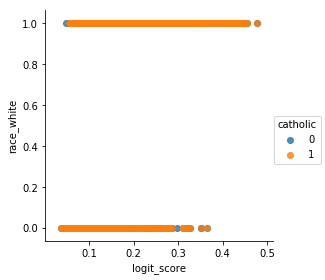

In [212]:
sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = final, size = 4, fit_reg = False)


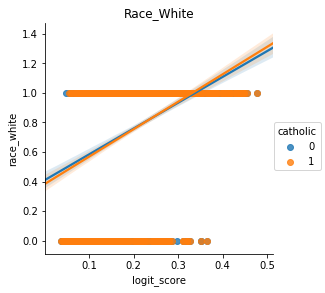

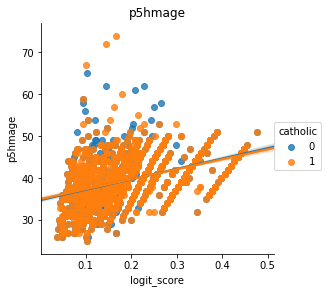

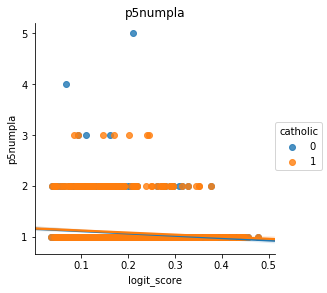

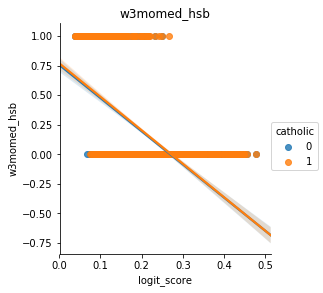

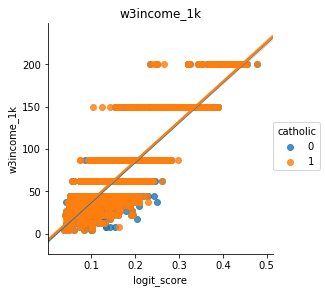

In [235]:

sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax1 = plt.gca()
ax1.set_title("Race_White")

sns.lmplot(x='logit_score', y='p5hmage', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax2 = plt.gca()
ax2.set_title("p5hmage")

sns.lmplot(x='logit_score', y='p5numpla', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax3 = plt.gca()
ax3.set_title("p5numpla")

sns.lmplot(x='logit_score', y='w3momed_hsb', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax4 = plt.gca()
ax4.set_title("w3momed_hsb")

sns.lmplot(x='logit_score', y='w3income_1k', hue='catholic',
           data = final, size = 4, fit_reg = True)
ax5 = plt.gca()
_=ax5.set_title("w3income_1k")


### After matching, we can see that when we plot a regression line, it is same for both catholic and public students. However if we plot similar graphs before matching, we can see the different in the regression line. This also confirms we have removed sample imbalance with matching.

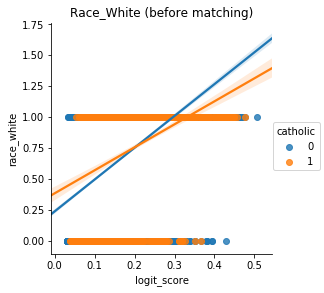

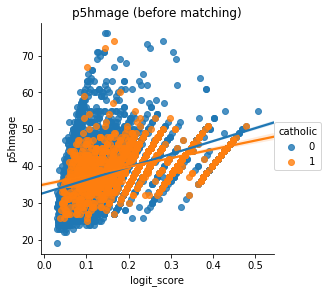

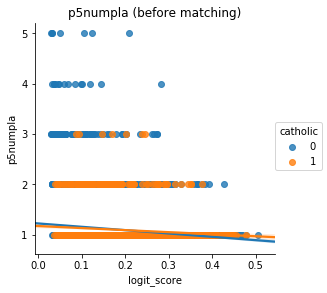

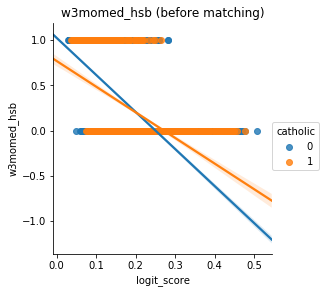

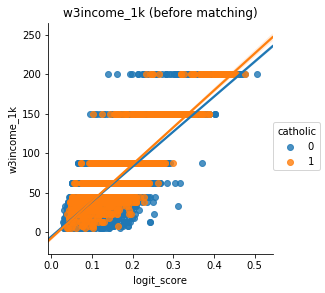

In [240]:
sns.lmplot(x='logit_score', y='race_white', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax1 = plt.gca()
ax1.set_title("Race_White (before matching)")

sns.lmplot(x='logit_score', y='p5hmage', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax2 = plt.gca()
ax2.set_title("p5hmage (before matching)")

sns.lmplot(x='logit_score', y='p5numpla', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax3 = plt.gca()
ax3.set_title("p5numpla (before matching)")

sns.lmplot(x='logit_score', y='w3momed_hsb', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax4 = plt.gca()
ax4.set_title("w3momed_hsb (before matching)")

sns.lmplot(x='logit_score', y='w3income_1k', hue='catholic',
           data = students, size = 4, fit_reg = True)
ax5 = plt.gca()
_=ax5.set_title("w3income_1k (before matching)")

,catholic,race_white,p5hmage,p5numpla,w3momed_hsb,w3income_1k,prop_score,logit_score
0,0,1,47.0,1.0,0.0,62.5005,0.226005,0.229293
1,0,1,41.0,1.0,0.0,45.0005,0.180133,0.180136
2,0,1,43.0,1.0,0.0,62.5005,0.208226,0.209296
3,1,1,38.0,1.0,0.0,87.5005,0.216810,0.215402
4,0,1,47.0,1.0,0.0,150.0005,0.355799,0.360493
